In [1]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

from helper_functions import delete_ds_store, plot_metrics, test, train, set_device, mean_std_finder, load_model
from CBAM import _CBAM
from MBNV3_2 import MBNV3Creator
from config import comet_token, project_name, workspace
from image_attention_vis import VisualizeAttention

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large, mobilenet_v3_small
from torchvision.models import MobileNet_V3_Large_Weights as weights_large, MobileNet_V3_Small_Weights as weights_small
import torchvision.transforms as transforms
from torchinfo import summary
from comet_ml import Experiment

import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM

#setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": None,
    "module_alias": "SE",
    "data_path": "/Users/leo/Desktop/Thesis/data/vgg_20/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 20,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": set_device(),
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace),
    "load_model": False,
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3Creator(prms["backbone"], prms["num_classes"], prms["weights"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/leothesouthafrican/test/3e388148bf2943c484157cc0571501e4



In [3]:
#mean, std = mean_std_finder(prms["data_path"])
mean, std = torch.tensor([0.3860, 0.3119, 0.2690]), torch.tensor([0.2279, 0.2167, 0.2135])

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


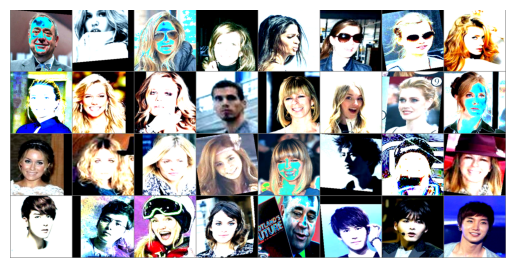

In [5]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [6]:
#build the model
model = load_model(model.build(), prms["model_save_path"]) if prms["load_model"] else model.build()

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
SE inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11]
Weights initialized for SE inserted in the following layers: [1, 4, 5, 6, 7, 8, 9, 10, 11] as well as the last layer.


In [7]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

/Users/leo/Desktop/Thesis/thesis_env/lib/python3.11/site-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 224, 224]     [1, 20]              --                   --                   --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432                  [3, 3]               5,419,008            True
│    │    └─BatchNorm2d (1)                                  [1, 16, 112, 112]    [1, 16, 112, 112]    32                   --              

In [8]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2, experiment = prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

100%|██████████| 44/44 [00:03<00:00, 11.88it/s]


Epoch: 01 | Epoch Time: 1.0m 27s
	Train Loss: 2.580 | Train Acc: 17.56%
	 Val. Loss: 3.157 |  Val. Acc: 4.90%
Best Accuracy Achieved: 4.90% on epoch 01


100%|██████████| 44/44 [00:03<00:00, 12.27it/s]


Epoch: 02 | Epoch Time: 1.0m 11s
	Train Loss: 2.462 | Train Acc: 20.63%
	 Val. Loss: 2.091 |  Val. Acc: 31.53%
Best Accuracy Achieved: 31.53% on epoch 02


100%|██████████| 44/44 [00:03<00:00, 11.82it/s]


Epoch: 03 | Epoch Time: 1.0m 12s
	Train Loss: 2.037 | Train Acc: 33.99%
	 Val. Loss: 1.870 |  Val. Acc: 40.34%
Best Accuracy Achieved: 40.34% on epoch 03


100%|██████████| 44/44 [00:03<00:00, 13.08it/s]


Epoch: 04 | Epoch Time: 1.0m 11s
	Train Loss: 1.800 | Train Acc: 41.42%
	 Val. Loss: 1.636 |  Val. Acc: 46.38%
Best Accuracy Achieved: 46.38% on epoch 04


100%|██████████| 44/44 [00:03<00:00, 12.91it/s]


Epoch: 05 | Epoch Time: 1.0m 9s
	Train Loss: 1.626 | Train Acc: 46.75%
	 Val. Loss: 1.420 |  Val. Acc: 51.63%
Best Accuracy Achieved: 51.63% on epoch 05


100%|██████████| 44/44 [00:03<00:00, 12.88it/s]


Epoch: 06 | Epoch Time: 1.0m 9s
	Train Loss: 1.483 | Train Acc: 51.22%
	 Val. Loss: 1.439 |  Val. Acc: 52.77%
Best Accuracy Achieved: 52.77% on epoch 06


100%|██████████| 44/44 [00:03<00:00, 12.55it/s]


Epoch: 07 | Epoch Time: 1.0m 10s
	Train Loss: 1.365 | Train Acc: 54.70%
	 Val. Loss: 1.252 |  Val. Acc: 58.10%
Best Accuracy Achieved: 58.10% on epoch 07


100%|██████████| 44/44 [00:03<00:00, 12.48it/s]


Epoch: 08 | Epoch Time: 1.0m 10s
	Train Loss: 1.235 | Train Acc: 59.00%
	 Val. Loss: 1.195 |  Val. Acc: 61.29%
Best Accuracy Achieved: 61.29% on epoch 08


100%|██████████| 44/44 [00:03<00:00, 11.91it/s]


Epoch: 09 | Epoch Time: 1.0m 9s
	Train Loss: 1.156 | Train Acc: 61.82%
	 Val. Loss: 1.134 |  Val. Acc: 63.85%
Best Accuracy Achieved: 63.85% on epoch 09


100%|██████████| 44/44 [00:03<00:00, 11.03it/s]


Epoch: 10 | Epoch Time: 1.0m 12s
	Train Loss: 1.063 | Train Acc: 65.11%
	 Val. Loss: 1.093 |  Val. Acc: 65.27%
Best Accuracy Achieved: 65.27% on epoch 10


100%|██████████| 44/44 [00:03<00:00, 12.09it/s]


Epoch: 11 | Epoch Time: 1.0m 14s
	Train Loss: 0.995 | Train Acc: 67.32%
	 Val. Loss: 1.022 |  Val. Acc: 65.20%


100%|██████████| 44/44 [00:03<00:00, 12.95it/s]


Epoch: 12 | Epoch Time: 1.0m 11s
	Train Loss: 0.915 | Train Acc: 69.27%
	 Val. Loss: 0.985 |  Val. Acc: 68.54%
Best Accuracy Achieved: 68.54% on epoch 12


 91%|█████████ | 323/355 [01:02<00:06,  5.19it/s]

In [ ]:
#test the model
test(model, test_loader, criterion, hyper_params = prms, experiment = prms["experiment"])

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leothesouthafrican/pytorch-mbnv3-faces-50/6e932ac7a0f84f4ab29db7d37c81e01a
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     inference_time  : 0.0070936596393585205
COMET INFO:     test_accuracy   : 0.8899999856948853
COMET INFO:     test_loss       : 0.3416920202970505
COMET INFO:     train_acc [50]  : (0.2610526382923126, 0.9908772110939026)
COMET INFO:     train_loss [50] : (0.032819434300293784, 3.0802719934363116)
COMET INFO:     val_acc [50]    : (0.10545454919338226, 0.9163636565208435)
COMET INFO:     val_loss [50]   : (0.34274567520079224, 4.108187457214703)
COMET INFO:   Parameters:
COMET INFO:     backbone        : <function mobilenet_v3_small at 0x176534040>
COMET INFO:     batch_size      : 16
COMET INFO:     data_path       

Test loss: 0.342.. 
Test accuracy: 0.890
Test Time: 0.0m 1s 418ms


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish before aborting...


(0.3416920202970505, tensor(0.8900, device='mps:0'))